In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(148, 152)
(148, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[4])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['HYP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[4])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(34, 152)
(34, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
interpolated_data_features.head()

,148,149,150,151,152,153,154,155,156,157,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,0.218164,0.278336,0.352055,0.260620,0.188693,0.249843,0.281885,0.190240,0.314775,0.145168,...,0.189897,0.223254,0.238971,0.205094,0.165601,0.213312,1,0.500000,11.0,1
1,0.122661,0.216212,0.268328,0.155556,0.091533,0.109173,0.075581,0.223510,0.124297,0.089184,...,0.106130,0.075360,0.130271,0.174976,0.082547,0.133865,0,0.750000,14.0,1
2,0.277826,0.379079,0.326287,0.411868,0.291031,0.325669,0.357791,0.171820,0.298320,0.150768,...,0.119550,0.156062,0.297822,0.326437,0.304810,0.462903,1,0.750000,8.0,1
3,0.357674,0.400751,0.323250,0.457499,0.382464,0.475292,0.492511,0.292449,0.367405,0.263515,...,0.282458,0.200812,0.268303,0.287545,0.313329,0.383266,1,0.916667,14.0,1
4,0.134840,0.257190,0.320982,0.256412,0.261020,0.296256,0.326458,0.375124,0.183223,0.116802,...,0.135763,0.194591,0.217846,0.378587,0.333081,0.181861,0,0.833333,10.0,1


In [5]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(230, 152)
(230, 152)
(230, 152)
(230, 152)
(232, 152)
(232, 152)
(232, 152)
(232, 152)


In [6]:
training_indices_X[0].head()

,148,149,150,151,152,153,154,155,156,157,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,0.307369,0.516999,0.434934,0.465464,0.569808,0.343587,0.352125,0.471307,0.338948,0.263369,...,0.307139,0.195980,0.442938,0.048999,0.429408,0.205990,1.0,0.750000,16.0,1.010959
1,0.155924,0.469559,0.373747,0.134533,0.197604,0.185067,0.148458,0.090487,0.180269,0.208591,...,0.044584,0.263017,0.341437,0.581531,0.469763,0.531485,0.0,0.500000,14.0,1.035616
2,0.269126,0.406813,0.786274,0.354072,0.389659,0.355645,0.518831,0.146444,0.349188,0.148000,...,0.422804,0.366829,0.730443,0.263909,0.410264,0.388674,1.0,0.916667,16.0,1.126027
3,0.402462,0.621980,0.421293,0.148542,0.277511,0.260444,0.198134,0.400102,0.273876,0.271722,...,0.112450,0.110412,0.246215,0.145806,0.275628,0.223729,0.0,0.583333,13.0,1.150685
4,0.293665,0.523100,0.435877,0.317015,0.473298,0.372287,0.554413,0.450949,0.734113,0.311900,...,0.232279,0.566873,0.859028,0.604834,0.626633,0.225424,1.0,0.750000,12.0,1.073973


In [7]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(230, 152)
(230, 152)
(230, 152)
(230, 152)
(232, 152)
(232, 152)
(232, 152)
(232, 152)
----------
(264, 152)
(264, 152)
(264, 152)
(264, 152)
(266, 152)
(266, 152)
(266, 152)
(266, 152)
Label shapes
(230, 1)
(230, 1)
(230, 1)
(230, 1)
(232, 1)
(232, 1)
(232, 1)
(232, 1)
----------
(264, 1)
(264, 1)
(264, 1)
(264, 1)
(266, 1)
(266, 1)
(266, 1)
(266, 1)


In [8]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [9]:
testing_fold_Y_1.shape

(19, 1)

In [10]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

D_in, H1, H2, D_out = 152, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 19
test_size1 = 18

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [11]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(19, 152)
(19, 152)
(19, 152)
(19, 152)
(18, 152)
(18, 152)
(18, 152)
(18, 152)


In [12]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [13]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model1's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.to(device)
print(model1)
weights1 = torch.FloatTensor([5]) #Class weights
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model2's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.to(device)
print(model2)
weights2 = torch.FloatTensor([5]) #Class weights
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model3's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.to(device)
print(model3)
weights3 = torch.FloatTensor([5]) #Class weights
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model4's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.to(device)
print(model4)
weights4 = torch.FloatTensor([5]) #Class weights
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model5's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.to(device)
print(model5)
weights5 = torch.FloatTensor([5]) #Class weights
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model6's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.to(device)
print(model6)
weights6 = torch.FloatTensor([5]) #Class weights
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model7's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.to(device)
print(model7)
weights7 = torch.FloatTensor([5]) #Class weights
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=152, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=152, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=152, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=152, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (laye

In [14]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.61771 | Acc: 44.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.41392 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41080 | Acc: 44.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.39968 | Acc: 44.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38682 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.38160 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.36474 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 008: | Loss: 1.35354 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.32871 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.29782 | Acc: 45.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.27377 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.24743 | Acc: 45.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.25320 | Acc: 45.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.18674 | Acc: 47.000
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.14269 | Acc: 46.444
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.10663 | Acc: 51.667
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.03998 | Acc: 50.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 018: | Loss: 0.97279 | Acc: 58.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 0.95600 | Acc: 63.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 0.91860 | Acc: 61.111

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  52.63157894736842  PPV |  [1.         0.18181818]  Recall |  [0.47058824 1.        ]
Training Epoch 021: | Loss: 0.84106 | Acc: 72.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 0.81043 | Acc: 71.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  36.84210526315789  PPV |  [1.         0.14285714]  Recall |  [0.29411765 1.        ]
Training Epoch 023: | Loss: 0.74789 | Acc: 71.556
Validation Accuracy |  42.10526315789473  PPV |  [1.         0.15384615]  Recall |  [0.35294118 1.        ]
Training Epoch 024: | Loss: 0.72375 | Acc: 73.000
Validation Accuracy |  68.42105263157895  PPV |  [0.86666667 0.        ]  Recall |  [0.76470588 0.        ]
Training Epoch 025: | Loss: 0.64730 | Acc: 80.556
Validation Accuracy |  26.31578947368421  PPV |  [1.    0.125]  Recall |  [0.17647059 1.        ]
Training Epoch 026: | Loss: 0.61938 | Acc: 81.889
Validation Accuracy |  57.89473684210527  PPV |  [1.  0.2]  Recall |  [0.52941176 1.        ]
Training Epoch 027: | Loss: 0.56976 | Acc: 82.444
Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 028: | Loss: 0.55467 | Acc: 81.889
Validation Accuracy |  68.42105263157895  PPV |  [0.92307692 0.16666667]  Re

Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 077: | Loss: 0.13757 | Acc: 96.444
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 078: | Loss: 0.18119 | Acc: 95.889
Validation Accuracy |  84.21052631578947  PPV |  [0.9375     0.33333333]  Recall |  [0.88235294 0.5       ]
Training Epoch 079: | Loss: 0.11946 | Acc: 97.333
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 080: | Loss: 0.09919 | Acc: 97.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 081: | Loss: 0.14522 | Acc: 98.111
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 082: | Loss: 0.09630 | Acc: 97.556
Validation Accuracy |  84.21052631578947  PPV |  [0.

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.58238 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.40486 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40831 | Acc: 44.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.40411 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38605 | Acc: 44.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36479 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.35345 | Acc: 45.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.33289 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 009: | Loss: 1.32893 | Acc: 44.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.31298 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 011: | Loss: 1.25104 | Acc: 45.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.22253 | Acc: 45.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.18362 | Acc: 46.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.15683 | Acc: 46.556


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.09965 | Acc: 48.444
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 016: | Loss: 1.02963 | Acc: 48.667
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 017: | Loss: 0.94486 | Acc: 58.778
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 018: | Loss: 0.89513 | Acc: 59.333
Validation Accuracy |  31.57894736842105  PPV |  [1.         0.13333333]  Recall |  [0.23529412 1.        ]
Training Epoch 019: | Loss: 0.81086 | Acc: 63.778
Validation Accuracy |  47.368421052631575  PPV |  [1.         0.16666667]  Recall |  [0.41176471 1.        ]
Training Epoch 020: | Loss: 0.78263 | Acc: 75.000
Validation Accuracy |  36.84210526315789  PPV |  [1.         0.

Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 067: | Loss: 0.16068 | Acc: 97.000
Validation Accuracy |  68.42105263157895  PPV |  [0.92307692 0.16666667]  Recall |  [0.70588235 0.5       ]
Training Epoch 068: | Loss: 0.14352 | Acc: 97.222
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 069: | Loss: 0.12800 | Acc: 98.444
Validation Accuracy |  73.68421052631578  PPV |  [0.92857143 0.2       ]  Recall |  [0.76470588 0.5       ]
Training Epoch 070: | Loss: 0.14458 | Acc: 96.333
Validation Accuracy |  68.42105263157895  PPV |  [0.86666667 0.        ]  Recall |  [0.76470588 0.        ]
Training Epoch 071: | Loss: 0.11515 | Acc: 96.222
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 072: | Loss: 0.09795 | Acc: 99.000
Validation Accuracy |  68.42105263157895  PPV |  [0.

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.70820 | Acc: 47.444
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.41914 | Acc: 45.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.45008 | Acc: 45.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.41402 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39667 | Acc: 45.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36872 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.36962 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.34729 | Acc: 45.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33961 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.31043 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.26724 | Acc: 45.000

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.24582 | Acc: 44.667
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.20520 | Acc: 45.667
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.17434 | Acc: 46.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.14390 | Acc: 49.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.09536 | Acc: 51.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.03155 | Acc: 54.111
Validation Accuracy |  15.789473684210526  PPV |  [1.         0.11111111]  Recall |  [0.05882353 1.        ]
Training Epoch 018: | Loss: 1.02444 | Acc: 52.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 0.94516 | Acc: 60.222
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 020: | Loss: 0.95903 | Acc: 58.333
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 021: | Loss: 0.91968 | Acc: 61.667
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.11764706]  Recall |  [0.11764706 1.        ]
Training Epoch 022: | Loss: 0.84798 | Acc: 75.333
Validation Accuracy |  15.789473684210526  PPV |  [1.         0.11111111]  Rec

Validation Accuracy |  78.94736842105263  PPV |  [0.93333333 0.25      ]  Recall |  [0.82352941 0.5       ]
Training Epoch 071: | Loss: 0.13493 | Acc: 97.778
Validation Accuracy |  78.94736842105263  PPV |  [0.93333333 0.25      ]  Recall |  [0.82352941 0.5       ]
Training Epoch 072: | Loss: 0.13082 | Acc: 98.111
Validation Accuracy |  78.94736842105263  PPV |  [0.93333333 0.25      ]  Recall |  [0.82352941 0.5       ]
Training Epoch 073: | Loss: 0.11793 | Acc: 96.667
Validation Accuracy |  78.94736842105263  PPV |  [0.93333333 0.25      ]  Recall |  [0.82352941 0.5       ]
Training Epoch 074: | Loss: 0.12673 | Acc: 97.778
Validation Accuracy |  63.1578947368421  PPV |  [0.91666667 0.14285714]  Recall |  [0.64705882 0.5       ]
Training Epoch 075: | Loss: 0.15750 | Acc: 96.667
Validation Accuracy |  78.94736842105263  PPV |  [0.93333333 0.25      ]  Recall |  [0.82352941 0.5       ]
Training Epoch 076: | Loss: 0.09123 | Acc: 99.000
Validation Accuracy |  73.68421052631578  PPV |  [0.9

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.63554 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.41844 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.42018 | Acc: 45.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.38648 | Acc: 44.667
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39580 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.35686 | Acc: 44.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.33086 | Acc: 45.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.29943 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.29068 | Acc: 45.222


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.24521 | Acc: 45.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.19500 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 012: | Loss: 1.16922 | Acc: 45.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.10087 | Acc: 46.444
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.05209 | Acc: 51.333
Validation Accuracy |  10.526315789473683  PPV |  [0.5        0.05882353]  Recall |  [0.05882353 0.5       ]
Training Epoch 015: | Loss: 0.98423 | Acc: 54.000
Validation Accuracy |  15.789473684210526  PPV |  [0.66666667 0.0625    ]  Recall |  [0.11764706 0.5       ]
Training Epoch 016: | Loss: 0.90853 | Acc: 60.444
Validation Accuracy |  47.368421052631575  PPV |  [0.88888889 0.1       ]  Recall |  [0.47058824 0.5       ]
Training Epoch 017: | Loss: 0.82224 | Acc: 70.889
Validation Accuracy |  42.10526315789473  PPV |  [0.875      0.09090909]  Recall |  [0.41176471 0.5       ]
Training Epoch 018: | Loss: 0.75177 | Acc: 71.778
Validation Accuracy |  42.105

Training Epoch 067: | Loss: 0.11877 | Acc: 98.556
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 068: | Loss: 0.09269 | Acc: 98.889
Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 069: | Loss: 0.11043 | Acc: 97.111
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 070: | Loss: 0.15275 | Acc: 95.889
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 071: | Loss: 0.10935 | Acc: 97.889
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 072: | Loss: 0.10857 | Acc: 99.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 073: | Loss: 0.12675 | Acc: 98.222
Va

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.52158 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.44347 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41093 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 004: | Loss: 1.38917 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38452 | Acc: 44.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.35775 | Acc: 45.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34626 | Acc: 45.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.31940 | Acc: 45.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.30968 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.27286 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.23294 | Acc: 45.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.18847 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.15319 | Acc: 46.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.06982 | Acc: 49.778

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 015: | Loss: 1.01673 | Acc: 54.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 0.97387 | Acc: 54.667
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.15384615]  Recall |  [0.3125 1.    ]
Training Epoch 017: | Loss: 0.92496 | Acc: 60.778
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 018: | Loss: 0.85862 | Acc: 65.111
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.15384615]  Recall |  [0.3125 1.    ]
Training Epoch 019: | Loss: 0.80316 | Acc: 72.667
Validation Accuracy |  44.44444444444444  PPV |  [0.8 0. ]  Recall |  [0.5 0. ]
Training Epoch 020: | Loss: 0.74001 | Acc: 72.556
Validation Accuracy |  66.66666666666666  PPV |  [0.85714286 0.        ]  Recall |  [0.75 0.  ]
Training Epoch 021: | Loss: 0.75453 | Acc: 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 069: | Loss: 0.12160 | Acc: 97.444
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 070: | Loss: 0.13015 | Acc: 96.667
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 071: | Loss: 0.10868 | Acc: 97.444
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 072: | Loss: 0.09648 | Acc: 98.556
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 073: | Loss: 0.07397 | Acc: 99.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 074: | Loss: 0.10700 | Acc: 97.444
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 075: | Loss: 0.10

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 087: | Loss: 0.04933 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 088: | Loss: 0.06714 | Acc: 98.889
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.06110 | Acc: 99.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 090: | Loss: 0.05945 | Acc: 98.333
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.09519 | Acc: 98.889
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 092: | Loss: 0.10359 | Acc: 96.556
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.06133 | Acc: 98.556
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 094: | Loss: 0.05193 | Acc: 99.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 095: | Loss: 0.05869 | Acc: 98.222
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 096: | Loss: 0.06021 | Acc: 98.444
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 097: | Loss: 0.05636 | Acc: 99.667
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 098: | Loss: 0.06088 | Acc: 97.778
Validation Accuracy |  88.88888888888889  PPV |  [0.888888

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.80258 | Acc: 43.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.49089 | Acc: 44.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39151 | Acc: 44.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.39536 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38072 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.40173 | Acc: 45.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.39125 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.37052 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.37127 | Acc: 45.444
Valida

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s


Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.33670 | Acc: 45.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.31602 | Acc: 45.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.28678 | Acc: 44.778


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.28530 | Acc: 45.444
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.22806 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.18216 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.16266 | Acc: 48.333

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s


Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.10553 | Acc: 48.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.06130 | Acc: 48.778
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 020: | Loss: 1.00126 | Acc: 56.222


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 021: | Loss: 0.87904 | Acc: 65.111
Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 022: | Loss: 0.78689 | Acc: 71.444
Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 023: | Loss: 0.80149 | Acc: 73.000
Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 024: | Loss: 0.76831 | Acc: 67.444
Validation Accuracy |  50.0  PPV |  [0.81818182 0.        ]  Recall |  [0.5625 0.    ]
Training Epoch 025: | Loss: 0.81684 | Acc: 72.778
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Training Epoch 026: | Loss: 0.67977 | Acc: 82.667
Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 027: | Loss: 0

Training Epoch 081: | Loss: 0.18621 | Acc: 94.778
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 082: | Loss: 0.14853 | Acc: 95.111
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 083: | Loss: 0.11444 | Acc: 97.111
Validation Accuracy |  66.66666666666666  PPV |  [0.85714286 0.        ]  Recall |  [0.75 0.  ]
Training Epoch 084: | Loss: 0.08845 | Acc: 98.556
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 085: | Loss: 0.07369 | Acc: 98.556
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 086: | Loss: 0.09130 | Acc: 98.222
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 087: | Loss: 0.09481 | Acc: 98.556
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Reca

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.84831 | Acc: 43.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.49760 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39643 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.39698 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39158 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 006: | Loss: 1.38471 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.36931 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.38236 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.35244 | Acc: 44.778
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.32865 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 011: | Loss: 1.33361 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.31647 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.26777 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.25987 | Acc: 44.778
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.22527 | Acc: 45.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.19319 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.14070 | Acc: 46.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.12691 | Acc: 50.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.07481 | Acc: 48.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.01392 | Acc: 56.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 0.89271 | Acc: 62.556
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 022: | Loss: 0.84410 | Acc: 68.667
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 023: | Loss: 0.81597 | Acc: 72.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 024: | Loss: 0.74101 | Acc: 74.000
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 025: | Loss: 0.75866 | Acc: 74.778
Validation Accuracy |  44.44444444444444  PPV |  [0.875 0.1  ]  Recall |  [0.4375 0.5   ]
Training Epoch 026: | Loss: 0.68437 | Acc: 79.444
Validation Accuracy |  44.44444444444444  PPV |  [0.875 0.1  ]  Recall |  [0.4375 0.5   ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 027: | Loss: 0.63417 | Acc: 80.778
Validation Accuracy |  44.44444444444444  PPV |  [0.875 0.1  ]  Recall |  [0.4375 0.5   ]
Training Epoch 028: | Loss: 0.60869 | Acc: 82.778
Validation Accuracy |  50.0  PPV |  [0.88888889 0.11111111]  Recall |  [0.5 0.5]
Training Epoch 029: | Loss: 0.57709 | Acc: 84.000
Validation Accuracy |  38.88888888888889  PPV |  [0.85714286 0.09090909]  Recall |  [0.375 0.5  ]
Training Epoch 030: | Loss: 0.61205 | Acc: 84.333
Validation Accuracy |  50.0  PPV |  [0.88888889 0.11111111]  Recall |  [0.5 0.5]
Training Epoch 031: | Loss: 0.58984 | Acc: 81.778
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 032: | Loss: 0.53063 | Acc: 84.222
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 033: | Loss: 0.49176 | Acc: 89.000
Validation Accuracy |  61.111111111111114  PPV |  [0.90909091 0.14285714]  Recall |  [0.625 0.5  ]
Train

Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 084: | Loss: 0.15395 | Acc: 94.778
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 085: | Loss: 0.12633 | Acc: 98.111
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 086: | Loss: 0.14768 | Acc: 96.778
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 087: | Loss: 0.11066 | Acc: 97.333
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 088: | Loss: 0.12700 | Acc: 95.778
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 089: | Loss: 0.13401 | Acc: 95.889
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]


In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.76492 | Acc: 51.667
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.44273 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.43943 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.40104 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39578 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 006: | Loss: 1.39056 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34974 | Acc: 44.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.35245 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33406 | Acc: 45.444
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.33697 | Acc: 45.222


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.29863 | Acc: 44.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.28379 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.23653 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.19760 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.16229 | Acc: 45.222


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.13736 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.08555 | Acc: 47.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.01820 | Acc: 50.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 0.96025 | Acc: 52.556
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 020: | Loss: 0.90017 | Acc: 64.000
Validation Accuracy |  16.666666666666664  PPV |  [1.         0.11764706]  Recall |  [0.0625 1.    ]
Training Epoch 021: | Loss: 0.87746 | Acc: 61.667
Validation Accuracy |  55.55555555555556  PPV |  [1.  0.2]  Recall |  [0.5 1. ]
Training Epoch 022: | Loss: 0.79366 | Acc: 70.333
Validation Accuracy |  66.66666666666666  PPV |  [0.91666667 0.16666667]  Recall |  [0.6875 0.5   ]
Training Epoch 023: | Loss: 0.74075 | Acc: 72.000
Validation Accuracy |  83.33333333333334  PPV |  [0.93333333 0.33333333]  Recall |  [0.875 0.5  ]
Training Epoch 024: | Loss: 0.70389 | Acc: 77.111
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 025: | Loss: 0.66471 | Acc: 80.889
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 026: | Loss: 0.58980 | Acc: 83.444
Validation Accuracy |  66.66666666666666  PPV |  [0.91666667 0.16666667]  Recal

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 041: | Loss: 0.29355 | Acc: 94.778
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 042: | Loss: 0.28266 | Acc: 93.333
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 043: | Loss: 0.29336 | Acc: 93.111
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 044: | Loss: 0.27959 | Acc: 96.556
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 045: | Loss: 0.25028 | Acc: 94.444
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 046: | Loss: 0.24798 | Acc: 94.667
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 047: | Lo

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 059: | Loss: 0.16089 | Acc: 96.778
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 060: | Loss: 0.17322 | Acc: 95.556
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 061: | Loss: 0.14448 | Acc: 95.111
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 062: | Loss: 0.13874 | Acc: 97.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 063: | Loss: 0.13239 | Acc: 96.222
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 064: | Loss: 0.12212 | Acc: 97.778
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 065: | Loss: 0.13087 | Acc: 98.333
Validation Accuracy |

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 070: | Loss: 0.10519 | Acc: 98.222
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 071: | Loss: 0.08174 | Acc: 98.556
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 072: | Loss: 0.14218 | Acc: 95.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 073: | Loss: 0.10705 | Acc: 97.889
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 074: | Loss: 0.08971 | Acc: 98.111
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 075: | Loss: 0.09571 | Acc: 98.778
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 076: | Loss: 0.10

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 085: | Loss: 0.07487 | Acc: 97.889
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.08434 | Acc: 98.556
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 087: | Loss: 0.07998 | Acc: 99.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 088: | Loss: 0.06017 | Acc: 99.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 089: | Loss: 0.05596 | Acc: 100.000
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 090: | Loss: 0.05281 | Acc: 98.444
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 095: | Loss: 0.04997 | Acc: 99.333
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 096: | Loss: 0.04759 | Acc: 98.889
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 097: | Loss: 0.04820 | Acc: 99.667
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 098: | Loss: 0.04289 | Acc: 98.556
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 099: | Loss: 0.06147 | Acc: 98.889
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 100: | Loss: 0.04999 | Acc: 98.556
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]


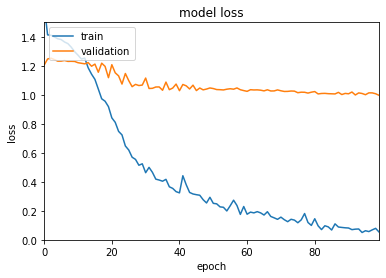

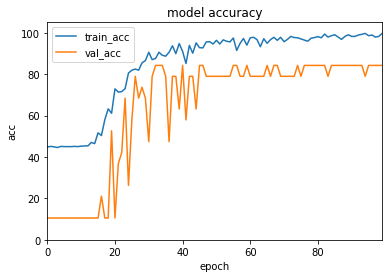

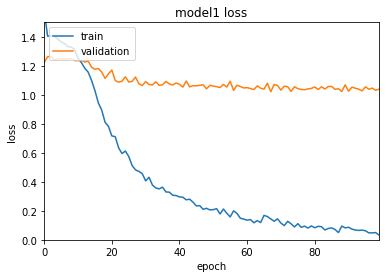

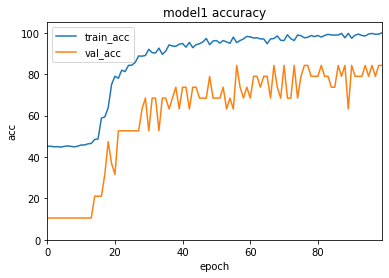

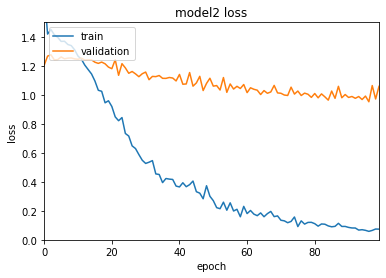

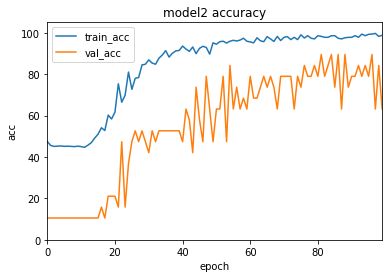

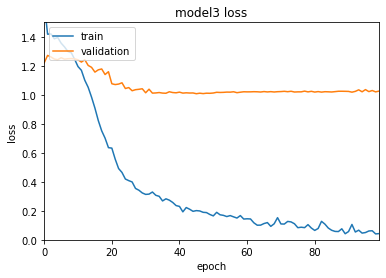

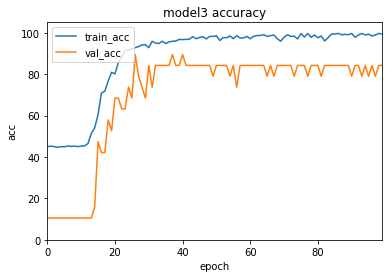

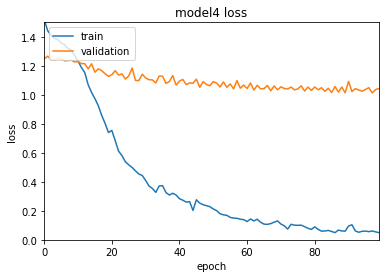

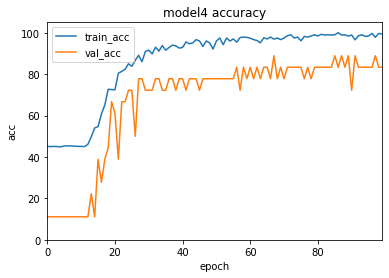

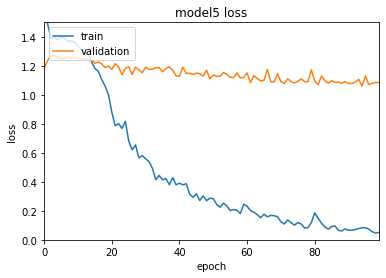

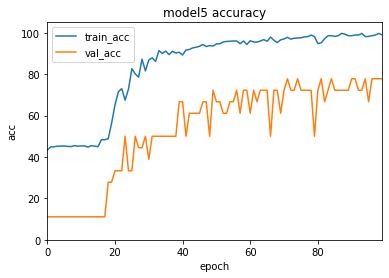

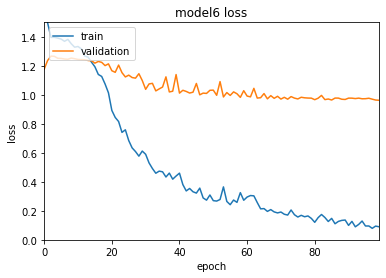

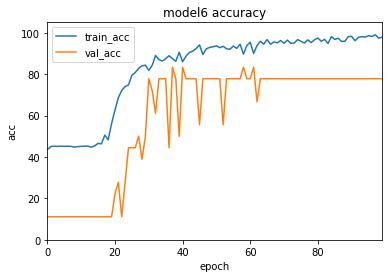

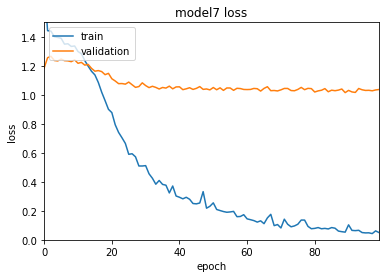

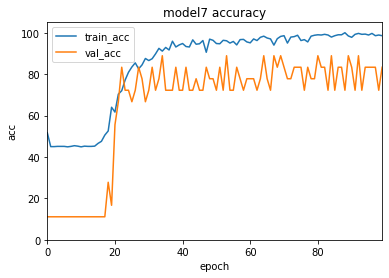

In [23]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]


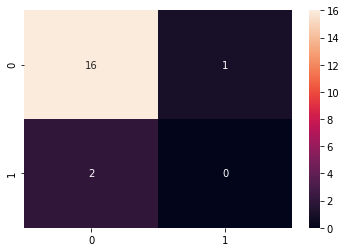

In [24]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]


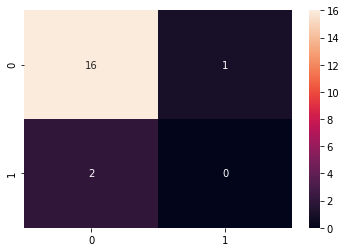

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  63.1578947368421  PPV |  [0.91666667 0.14285714]  Recall |  [0.64705882 0.5       ]


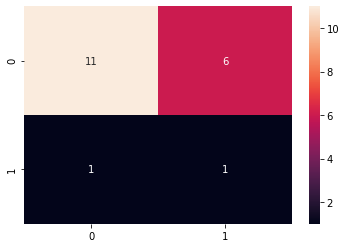

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]


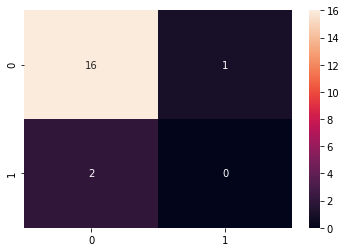

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]


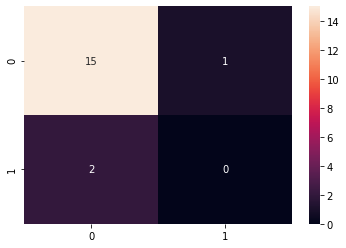

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]


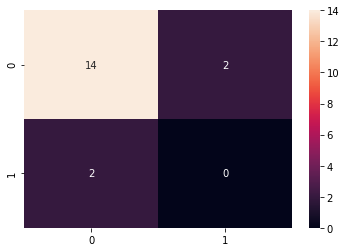

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]


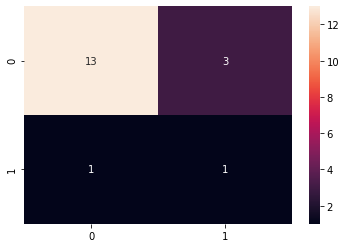

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]


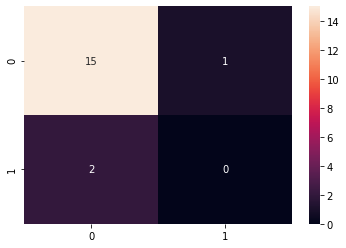

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [32]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[116  16]
 [ 14   2]]
Positive Predictive Value tp/(tp+fp):  0.1111111111111111
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.7972972972972973
Recall Value tp/(tp+fn):  0.125


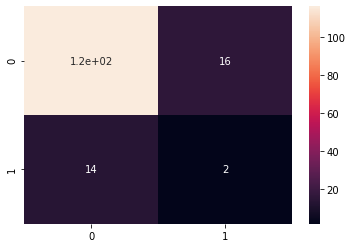

In [33]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 